File or folder: C:\Users\nazih\satellite-aukf-assignment\orekit-data.zip  not found


            The Orekit library relies on some external data for physical models.
            Typical data are the Earth Orientation Parameters and the leap seconds history,
            both being provided by the IERS or the planetary ephemerides provided by JPL.
            Such data is stored in text or binary files with specific formats that Orekit knows
            how to read, and needs to be provided for the library to work.

            You can download a starting file with this data from the orekit gitlab at:
            https://gitlab.orekit.org/orekit/orekit-data

            or by the function:
            orekit.pyhelpers.download_orekit_data_curdir()

            
✔️  Orekit data registered: C:\Users\nazih\satellite-aukf-assignment\orekit-data


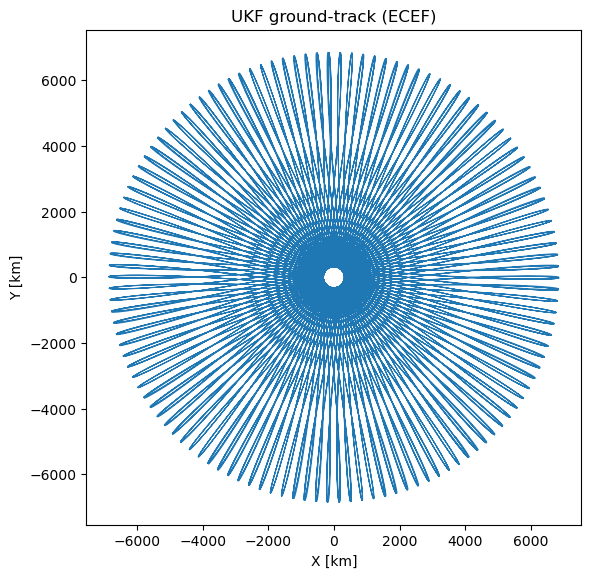

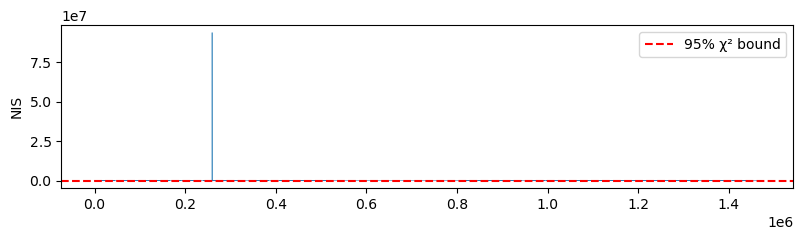

In [1]:
# 02_filter_demo.ipynb

import json, matplotlib.pyplot as plt
import numpy as np, pandas as pd
from scipy.stats import chi2

from utils  import OrbitPropagator    # auto‐registers data
from aukf   import UnscentedKalman

# ---- data -------------------------------------------------------
df  = pd.read_parquet("GPS_clean.parquet")
cols = json.load(open("meas_cols.json"))
grouped = df.groupby("time", sort=True)

# ---- propagator -------------------------------------------------
prop = OrbitPropagator()

# ---- UKF + innovation log ---------------------------------------
ukf = UnscentedKalman(prop, cols,
                      q0=1e-2, r0=25.0, adaptive="sage-husa")
ukf.innov = []  # initialise residual list

# ---- init -------------------------------------------------------
t0 = next(iter(grouped.groups))
Z0 = grouped.get_group(t0)[cols].mean().values
ukf.init_from_measurement(0.0, Z0)

# ---- run --------------------------------------------------------
prev_t = t0
for t, g in grouped:
    if t == t0: continue
    dt = (t - prev_t).total_seconds()
    Z  = g[cols].mean().values
    ukf.step(dt, Z)
    ukf.innov.append( (Z - ukf.x).copy() )
    prev_t = t

# stack and compute NIS
ukf.innov = np.vstack(ukf.innov)
dof      = ukf.dim_z
nis      = np.sum((ukf.innov / np.sqrt(np.diag(ukf.R)))**2, axis=1)
upper95  = chi2.ppf(0.95, dof)

# ---- ground-track plot -----------------------------------------
xs = np.array([h[1] for h in ukf.history])
plt.figure(figsize=(6,6))
plt.plot(xs[:,0]/1e3, xs[:,1]/1e3, lw=0.6)
plt.gca().set_aspect("equal")
plt.xlabel("X [km]"); plt.ylabel("Y [km]")
plt.title("UKF ground-track (ECEF)")
plt.tight_layout()
plt.show()

# ---- NIS consistency check --------------------------------------
plt.figure(figsize=(8,2.5))
plt.plot(nis, lw=0.4)
plt.axhline(upper95, ls="--", c="r", label="95% χ² bound")
plt.ylabel("NIS"); plt.legend(); plt.tight_layout(); plt.show()
